<a href="https://colab.research.google.com/github/Gustavo-br-rj/PROJ-BI_MASTER/blob/main/4_PREVER_TEMP_MANCAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Previsão de Série Temporal da Temperatura de Mancais Utilizando LSTM


## Parte 0 - Importação das Bibliotecas

In [2]:
#%tensorflow_version 1.x
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import math
import json

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

#tf.__version__

## Parte 1 - Importação do Dataset e Predição dos Valores de Temperatura dos Mancais

In [3]:
# Importação da Base de Dados
dataset = pd.read_csv('/content/drive/MyDrive/BI_MASTER/PROJETO_FINAL_BIMASTER/DATASETS/dataset_C-4451_08001A.csv')

In [4]:
#Conversão do campo data para datetime e ordenação do dataset
dataset['DATA'] = pd.to_datetime(dataset['DATA'],dayfirst=True)
dataset = dataset.sort_values(['EQUIPAMENTO', 'MANCAL', 'DATA'], ascending=[1, 1, 1])

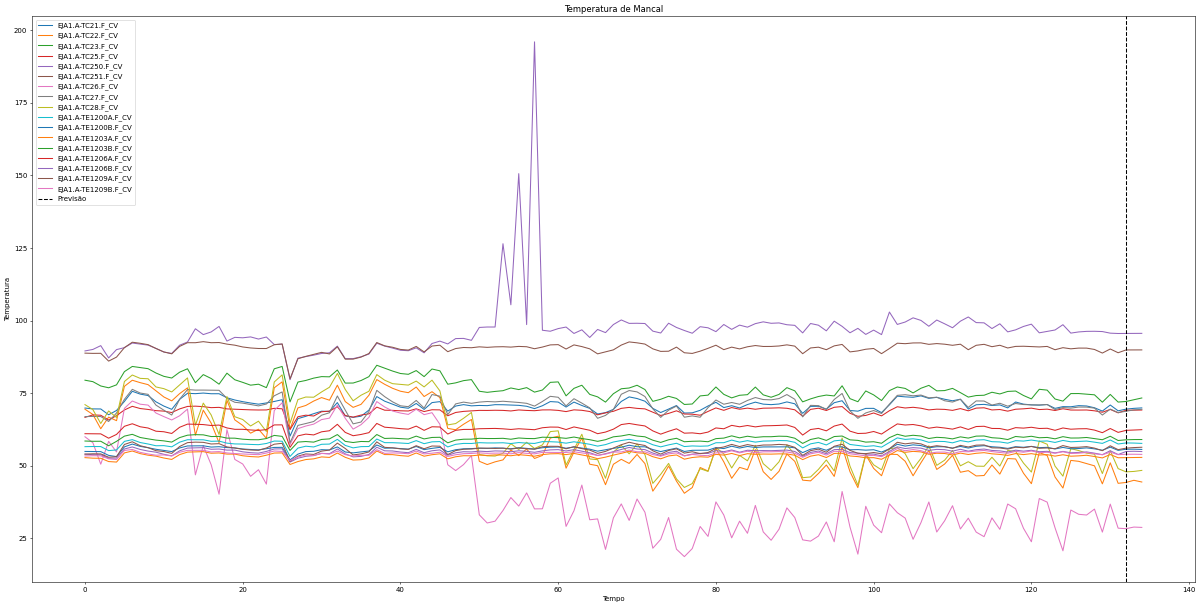

In [5]:
#Diretório dos modelos de RN para cada mancal
dirModel = '/content/drive/MyDrive/BI_MASTER/PROJETO_FINAL_BIMASTER/MODELOS/'

#Buscando a identificação dos mancais
mancais = dataset['MANCAL'].unique().tolist()

#Lista de saídas para avaliação das premissas para alerta
saidas = pd.DataFrame()  

plt.figure(figsize=(30, 15), dpi=50)

for i in range(len(mancais)):
  manc = dataset.loc[(dataset["MANCAL"] == mancais[i]), ["EQUIPAMENTO","MANCAL","DATA","TEMPERATURA"]]
  manc = manc.reset_index(drop=True)

  nomeModelo  = '{0}{1}__{2}_model'.format(dirModel,manc['EQUIPAMENTO'].to_numpy()[0], manc['MANCAL'].to_numpy()[0])
  paramModelo = '{0}{1}__{2}_params.json'.format(dirModel,manc['EQUIPAMENTO'].to_numpy()[0], manc['MANCAL'].to_numpy()[0])

  #Obtendo o arquivo de parâmetros
  f_json = open(paramModelo,)
  json_param = json.load(f_json)
  f_json.close()

  #Reconstruindo o modelo
  reconstructed_model = load_model(nomeModelo)

  #Pegando a última janela de dados do conjunto
  window = json_param["window"]
  last_window_set = manc.tail(window)
  last_window_set = last_window_set.iloc[0:window, 3:4].values

  #Normalizando
  sc = MinMaxScaler(feature_range = (0, 1))
  last_window_set_scaled = sc.fit_transform(last_window_set)

  #Prever temperatura
  output = json_param["output"]
  X_last_window = [] 
  X_last_window.append(last_window_set_scaled[0:window, 0])
  X_last_window = np.array(X_last_window)
  X_last_window = np.reshape(X_last_window, (X_last_window.shape[0], X_last_window.shape[1], 1))

  predicted = reconstructed_model.predict(X_last_window)
  predicted = sc.inverse_transform(predicted)

  all_entries = manc.iloc[:,3:4].values
  temperaturas = np.insert(all_entries,len(all_entries),predicted[0])
  
  # pegar a média dos últimos 6 meses
  dias = 6*30
  last_entries = all_entries[-dias:]
  media_sem    = last_entries.mean()

  # pegar última temperatura prevista
  previsao     = predicted[0][output-1]

  # Adicionar a média e a previsão em um array contendo o nome do mancal
  #saidas = np.insert(saidas,len(saidas),(mancais[i],media_sem,previsao))
  saida   = {'Mancal': mancais[i], 'Media Semestral':media_sem, 'Previsão':previsao}  
  saidas  = saidas.append(saida, ignore_index=True) 

  plt.plot(temperaturas, label=mancais[i])


plt.axvline(x=len(all_entries), label='Previsão', c='k',ls='--')
plt.xlabel("Tempo")
plt.ylabel("Temperatura")
plt.title("Temperatura de Mancal")
plt.legend()
plt.show()

## Parte 2 - Verificação das premissas

- Desvio de 40% na temperatura do mancal em relação a média de todos mancais do equipamento no mesmo dia.
- Desvio de 20% na temperatura do mancal em relação a sua média semestral.

In [6]:
print(saidas)

                 Mancal  Media Semestral   Previsão
0      EJA1.A-TC21.F_CV        70.833152  69.934799
1      EJA1.A-TC22.F_CV        57.846730  44.416603
2      EJA1.A-TC23.F_CV        77.017574  73.353447
3      EJA1.A-TC25.F_CV        68.938010  69.203682
4     EJA1.A-TC250.F_CV        96.623690  95.608849
5     EJA1.A-TC251.F_CV        90.443163  89.910461
6      EJA1.A-TC26.F_CV        42.626431  28.778366
7      EJA1.A-TC27.F_CV        71.007189  69.456345
8      EJA1.A-TC28.F_CV        60.260606  48.411469
9   EJA1.A-TE1200A.F_CV        57.821161  57.714405
10  EJA1.A-TE1200B.F_CV        55.924279  55.634159
11  EJA1.A-TE1203A.F_CV        53.570481  52.891209
12  EJA1.A-TE1203B.F_CV        59.373717  59.044483
13  EJA1.A-TE1206A.F_CV        62.614982  62.431446
14  EJA1.A-TE1206B.F_CV        54.828215  54.906696
15  EJA1.A-TE1209A.F_CV        55.979346  56.385033
16  EJA1.A-TE1209B.F_CV        54.325886  53.928204


In [7]:
# Retorna a lista flat de uma lista composta por listas de um único item 
def toFlatList(lista):
  lista_aux = lista.tolist()
  flat_list = []
  for i in range(len(lista_aux)):
    flat_list.append(lista_aux[i][0])
  
  return flat_list

####Desvio de 40% na temperatura do mancal em relação a média de todos mancais do equipamento no mesmo dia.

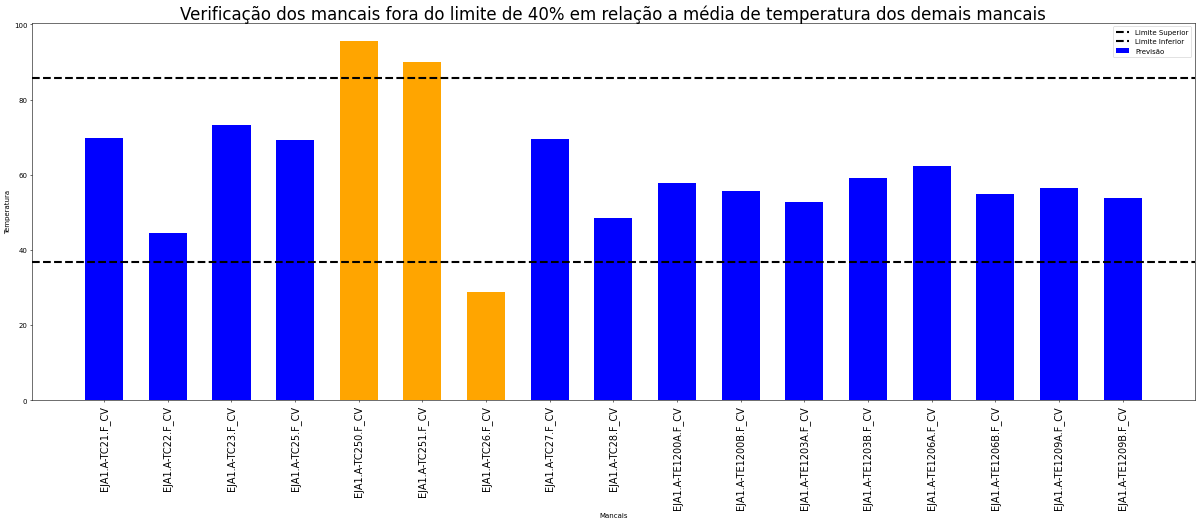

In [12]:
# Calculando os limites para identificação de desvios de 40% em relação a média dos mancais
mancais   = saidas.iloc[:, 0:1].values
previsoes = saidas.iloc[:, 2:3].values

media_previsoes = previsoes.mean()
perc40_media_prev = media_previsoes * 0.40
lim_inferior_med_prev = media_previsoes - perc40_media_prev
lim_superior_med_prev = media_previsoes + perc40_media_prev

flat_list_mancais = toFlatList(mancais)
flat_list_previsoes = toFlatList(previsoes)

plt.figure(figsize=(30, 10), dpi=50)

plt.axhline(y=lim_superior_med_prev, label='Limite Superior', c='k',ls='--', linewidth=3.0)
plt.axhline(y=lim_inferior_med_prev, label='Limite Inferior', c='k',ls='--', linewidth=3.0)

width = 0.6
colors = ["orange" if (i < lim_inferior_med_prev or i>lim_superior_med_prev) else "blue" for i in flat_list_previsoes]
plt.bar(flat_list_mancais, flat_list_previsoes, width, color=colors, label="Previsão")
plt.xticks(range(len(flat_list_mancais)), flat_list_mancais, rotation='vertical',fontsize=14)

plt.xlabel("Mancais")
plt.ylabel("Temperatura")
plt.title("Verificação dos mancais fora do limite de 40% em relação a média de temperatura dos demais mancais", fontsize=24)
plt.legend()
plt.show()

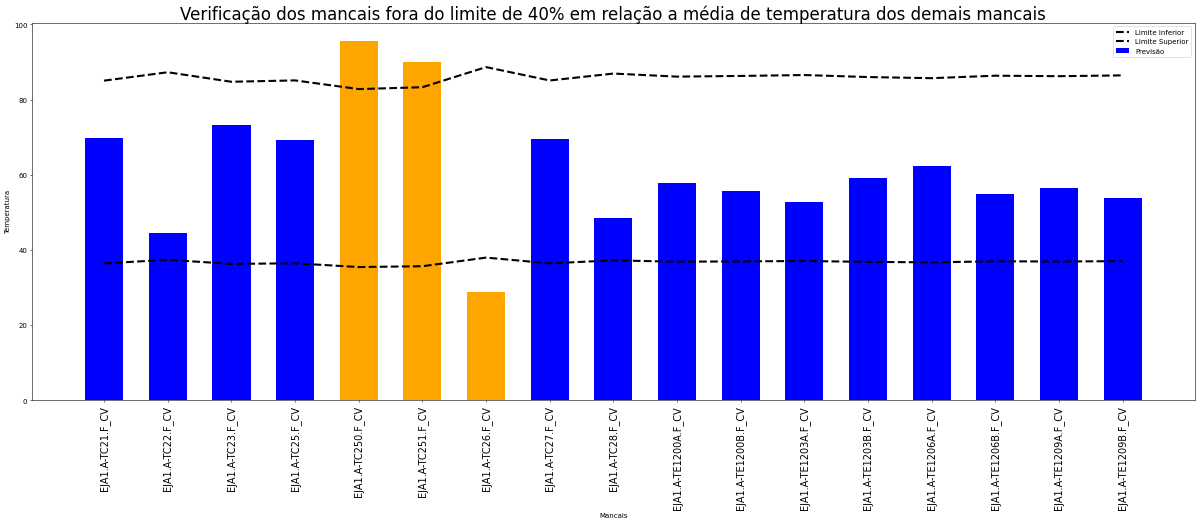

In [13]:
# Calculando os limites para identificação de desvios de 40% em relação a média dos mancais excluindo o mancal avaliado
medias_previsoes_outros_mancais = []
limites_inferiores = []
limites_superiores = []

for i in range(len(mancais)):
  outras_previsoes = toFlatList(previsoes)
  outras_previsoes.pop(i)

  media_outras_previsoes = np.array(outras_previsoes).mean()
  medias_previsoes_outros_mancais.append(media_outras_previsoes)

  perc40_media_prev_outros = media_outras_previsoes * 0.40
  lim_inferior_med_prev_outros = media_outras_previsoes - perc40_media_prev_outros
  lim_superior_med_prev_outros = media_outras_previsoes + perc40_media_prev_outros

  limites_inferiores.append(lim_inferior_med_prev_outros)
  limites_superiores.append(lim_superior_med_prev_outros)


plt.figure(figsize=(30, 10), dpi=50)

width = 0.6

colors = ["orange" if (flat_list_previsoes[i] < limites_inferiores[i] or flat_list_previsoes[i]>limites_superiores[i]) else "blue" for i in range(len(flat_list_previsoes))]

plt.bar(flat_list_mancais, flat_list_previsoes, width, color=colors,  label='Previsão')
plt.plot(limites_inferiores, color="black", ls='--', label='Limite Inferior', linewidth=3.0)
plt.plot(limites_superiores, color="black", ls='--', label='Limite Superior', linewidth=3.0)

plt.xticks(range(len(flat_list_mancais)), flat_list_mancais, rotation='vertical',fontsize=14)

plt.xlabel("Mancais")
plt.ylabel("Temperatura")
plt.title("Verificação dos mancais fora do limite de 40% em relação a média de temperatura dos demais mancais", fontsize=24)
plt.legend()
plt.show()

####Desvio de 20% na temperatura do mancal em relação a sua média semestral.

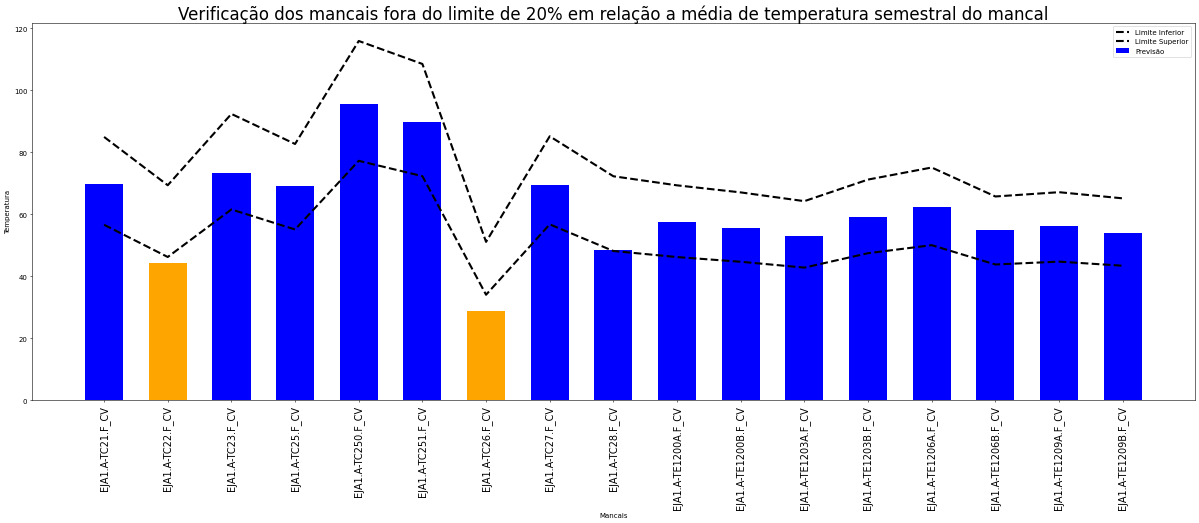

In [14]:
# Calculando os limites para identificação de desvios de 20% em relação a média semestral do mancal avaliado
limites_inferiores = []
limites_superiores = []

medias_semestrais = saidas.iloc[:, 1:2].values

for i in range(len(mancais)):
  outras_previsoes = toFlatList(previsoes)
  outras_previsoes.pop(i)

  media_semestral = medias_semestrais[i]

  perc20_media_sem = media_semestral * 0.20
  lim_inferior_med_sem = media_semestral - perc20_media_sem
  lim_superior_med_sem = media_semestral + perc20_media_sem

  limites_inferiores.append(lim_inferior_med_sem)
  limites_superiores.append(lim_superior_med_sem)


plt.figure(figsize=(30, 10), dpi=50)

width = 0.6

colors = ["orange" if (flat_list_previsoes[i] < limites_inferiores[i] or flat_list_previsoes[i]>limites_superiores[i]) else "blue" for i in range(len(flat_list_previsoes))]

plt.bar(flat_list_mancais, flat_list_previsoes, width, color=colors,  label='Previsão')
plt.plot(limites_inferiores, color="black", ls='--', label='Limite Inferior', linewidth=3.0)
plt.plot(limites_superiores, color="black", ls='--', label='Limite Superior', linewidth=3.0)

plt.xticks(range(len(flat_list_mancais)), flat_list_mancais, rotation='vertical',fontsize=14)

plt.xlabel("Mancais")
plt.ylabel("Temperatura")
plt.title("Verificação dos mancais fora do limite de 20% em relação a média de temperatura semestral do mancal", fontsize=24)
plt.legend()
plt.show()